In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Input,Conv2D,GlobalAveragePooling2D,BatchNormalization,DepthwiseConv2D,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

In [9]:
IMG_SIZE=40,40
BATCH_SIZE=32
SEED=5
AUTO=tf.data.AUTOTUNE

In [12]:
def create_images_list(path):
    full_path=[]
    images=os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path,i))
    return full_path    

In [13]:
data_moon = create_images_list('/kaggle/input/jellyfish-types/Moon_jellyfish')
data_barrel = create_images_list('/kaggle/input/jellyfish-types/barrel_jellyfish')
data_blue = create_images_list('/kaggle/input/jellyfish-types/blue_jellyfish')
data_compass = create_images_list('/kaggle/input/jellyfish-types/compass_jellyfish')
data_lions_mane = create_images_list('/kaggle/input/jellyfish-types/lions_mane_jellyfish')
data_mauve_stinger = create_images_list('/kaggle/input/jellyfish-types/mauve_stinger_jellyfish')

In [15]:
jellyfish_classes = {0:'Moon', 1 : 'Barrel', 2 : 'Blue', 3 : 'Compass', 4 : 'Lion’s mane', 5: 'Mauve stinger'}


data_df = pd.concat([pd.DataFrame({"img" : np.array(data_moon) , "label": 0 }),
                     pd.DataFrame({"img" : np.array(data_barrel) , "label": 1 }),
                     pd.DataFrame({"img" : np.array(data_blue) , "label": 2 }),
                     pd.DataFrame({"img" : np.array(data_compass) , "label": 3 }),
                     pd.DataFrame({"img" : np.array(data_lions_mane) , "label": 4 }),
                     pd.DataFrame({"img" : np.array(data_mauve_stinger) , "label": 5 }) ], ignore_index = True)

data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)
data_df.head()

,img,label
0,/kaggle/input/jellyfish-types/compass_jellyfis...,3
1,/kaggle/input/jellyfish-types/lions_mane_jelly...,4
2,/kaggle/input/jellyfish-types/mauve_stinger_je...,5
3,/kaggle/input/jellyfish-types/mauve_stinger_je...,5
4,/kaggle/input/jellyfish-types/Moon_jellyfish/a...,0


In [16]:
test_idx=data_df.shape[0]*15//100
train_df=data_df[test_idx:].reset_index(drop=True)
test_df=data_df[:test_idx].reset_index(drop=True)
print("train_df(train and val) shape->",train_df.shape[0])
print("test_df shape->",test_df.shape[0])

train_df(train and val) shape-> 765
test_df shape-> 135


In [17]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

In [19]:
FEATURES=256
inp=Input(shape=(*IMG_SIZE,3))

X=Conv2D(FEATURES,2,2)(inp)
X=Activation('gelu')(X)
X=BatchNormalization()(X)

X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_1')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_2')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_3')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_4')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_5')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_6')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_7')(X)
X=ConvMixerBlock(FEATURES,5,2,name='CONVMIXER_8')(X)

X = GlobalAveragePooling2D()(X)
out = Dense(6, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)
model.summary()
    
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 256)       3328      
                                                                 
 activation (Activation)     (None, 20, 20, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 256)      1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 20, 20, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 20, 20, 256)      74496 

In [21]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    
    return image, label

In [23]:
test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [24]:
fold_hists = []
test_evals = []
test_preds = []

EPOCHS = 20
FOLDS = 10

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):
    
    print('-'*90)
    print(str(i+1) + '.fold training')
    
    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]
    
    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]


    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    
    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)
    fold_hists.append(hist)
    
    # Test evaluation
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training
5/5 [==============================] - 0s 45ms/step - loss: 5.4519 - acc: 0.1556 - top_3_acc: 0.5407
Test Loss: 5.452
Test Accuracy: 15.556 %
Test Sparse Top 2 Accuracy: 54.07 %
5/5 [==============================] - 1s 12ms/step
------------------------------------------------------------------------------------------
2.fold training
5/5 [==============================] - 0s 12ms/step - loss: 0.5710 - acc: 0.7926 - top_3_acc: 0.9852
Test Loss: 0.571
Test Accuracy: 79.259 %
Test Sparse Top 2 Accuracy: 98.52 %
5/5 [==============================] - 0s 12ms/step
------------------------------------------------------------------------------------------
3.fold training
5/5 [==============================] - 0s 12ms/step - loss: 0.4808 - acc: 0.8519 - top_3_acc: 0.9926
Test Loss: 0.481
Test Accuracy: 85.185 %
Test Sparse Top 2 Accuracy: 99.26 %
5/5 [==============================] - 0s

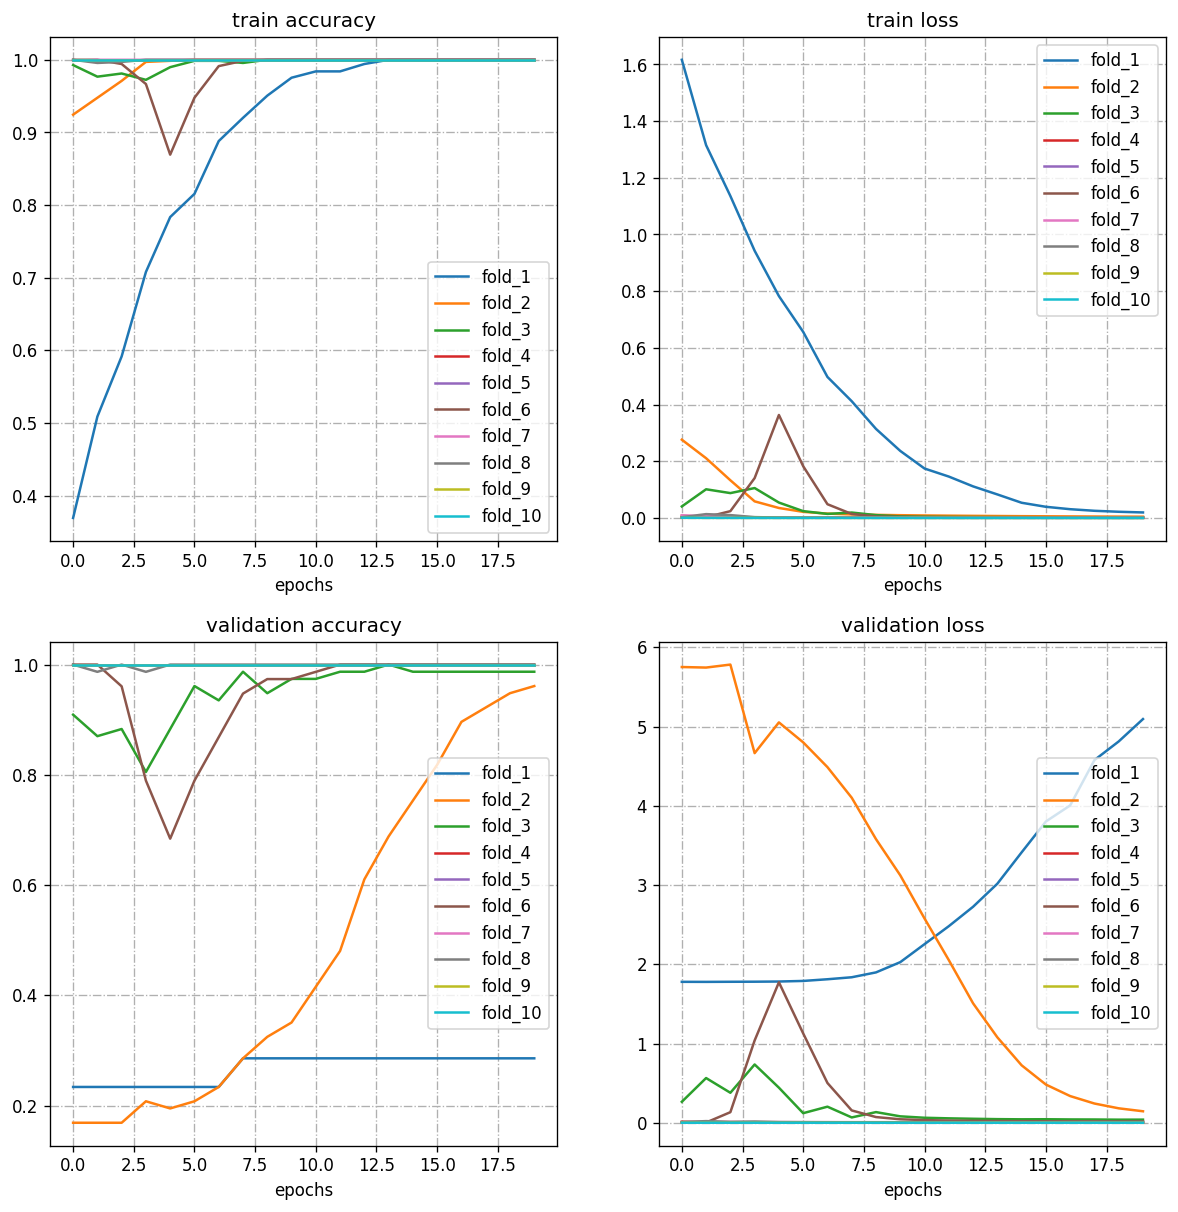

In [25]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)

In [27]:
preds=np.mean(test_preds,axis=0)
last_pred=np.argmax(preds,axis=1)

In [28]:
clf=classification_report(test_df['label'],last_pred,target_names=list(jellyfish_classes.values()))
print(clf)

               precision    recall  f1-score   support

         Moon       0.81      0.81      0.81        16
       Barrel       0.82      0.95      0.88        19
         Blue       0.93      0.79      0.85        33
      Compass       0.90      0.86      0.88        21
  Lion’s mane       0.70      0.88      0.78        16
Mauve stinger       0.90      0.87      0.88        30

     accuracy                           0.85       135
    macro avg       0.84      0.86      0.85       135
 weighted avg       0.86      0.85      0.85       135



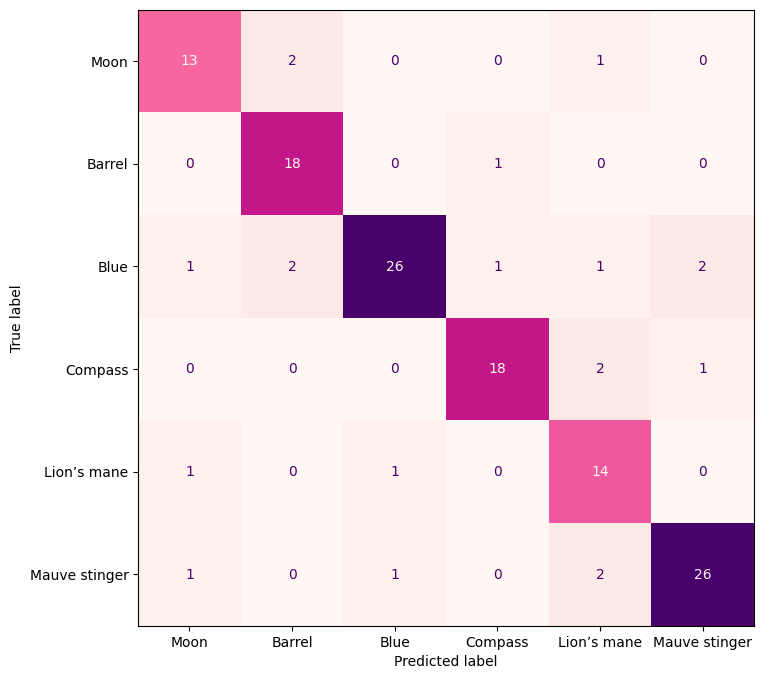

In [29]:
cm=confusion_matrix(test_df['label'],last_pred)
cmd=ConfusionMatrixDisplay(cm,display_labels=list(jellyfish_classes.values()))

fig,ax=plt.subplots(figsize=(8,8))
cmd.plot(ax=ax,cmap='RdPu',colorbar=False)

In [30]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
    
def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'red')

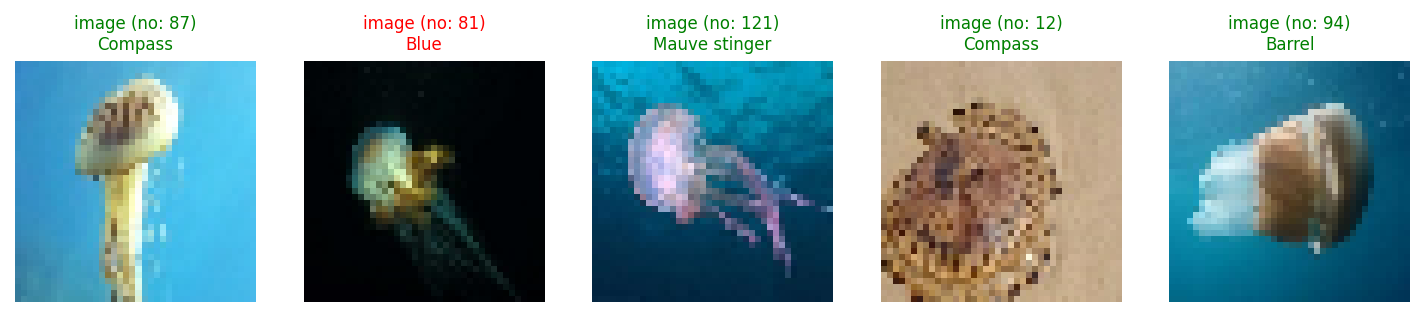

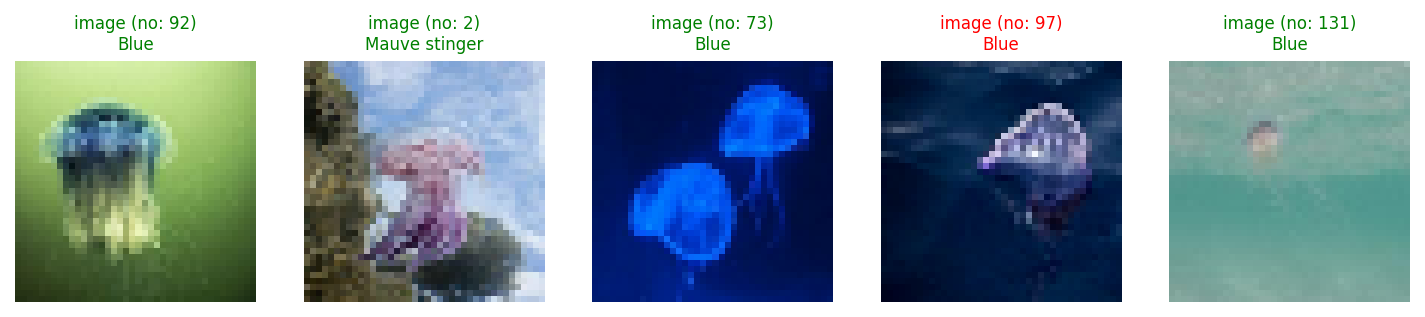

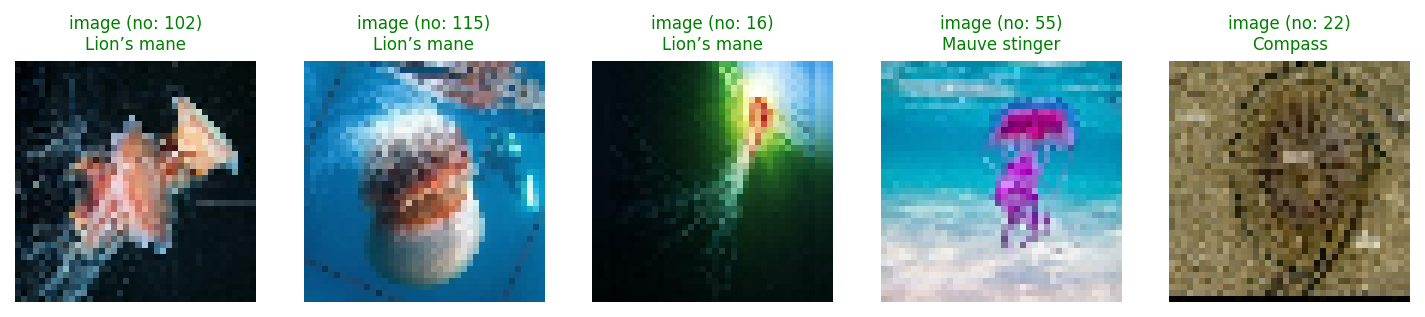

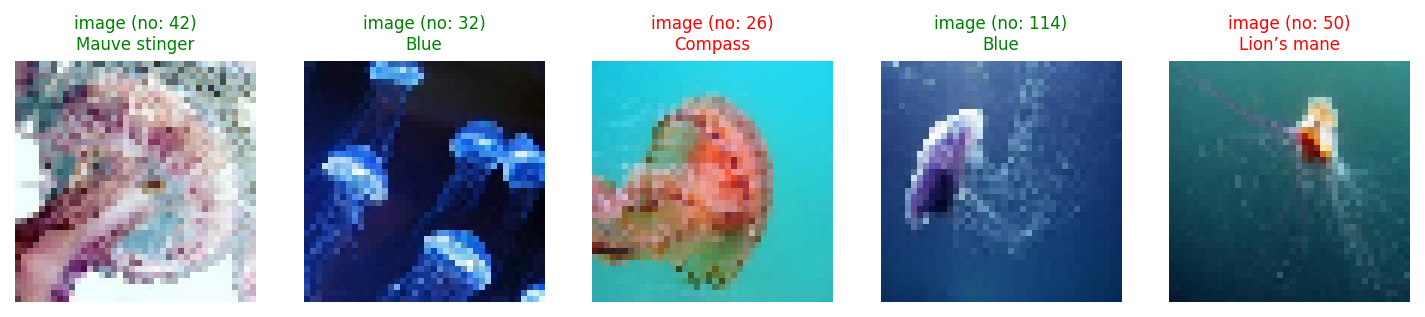

In [31]:
random_test_sample_with_prediction(SEED = 145)
random_test_sample_with_prediction(SEED = 7)
random_test_sample_with_prediction(SEED = 78)
random_test_sample_with_prediction(SEED = 98)